# Final Project: Image Captioning

## 1. Problem Description

### 1.1 Project Goal
The goal of this project is to build a deep learning model that can automatically generate a descriptive text caption for a given image. This is a fascinating multimodal problem that combines techniques from both Computer Vision and Natural Language Processing (NLP).

### 1.2 Model Architecture: An Encoder-Decoder Approach
To solve this, we will implement an **encoder-decoder** model, a common architecture for this type of task.
- **Encoder:** We will use a pretrained Convolutional Neural Network (CNN), specifically VGG16, to process the input image. The CNN will act as a feature extractor, converting the raw image pixels into a rich vector representation that captures the key objects and scenes in the image. This leverages the power of transfer learning.
- **Decoder:** We will use a Recurrent Neural Network (RNN), specifically an LSTM (Long Short Term Memory) network, to generate the caption. The LSTM will take the feature vector from the encoder as its initial input and generate the caption one word at a time, learning the structure and vocabulary of natural language.

### 1.3 Data Source
The dataset used is the Flickr8k dataset, which contains 8,000 images, each paired with five different human generated captions.
- **Source:** [Kaggle: Flickr 8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)

In [1]:
!pip install tensorflow

# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import numpy as np
import matplotlib.pyplot as plt

2025-10-14 13:48:54.739897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Exploratory Data Analysis (EDA) and Preprocessing

We'll start by loading and inspecting the `captions.txt` file to understand how the image names and their corresponding captions are structured.

In [5]:
# Define the path to your data
CAPTIONS_PATH = 'archive/captions.txt'

# Load the captions file
with open(CAPTIONS_PATH, 'r') as f:
    captions_doc = f.read()

# Let's see the first few lines to understand the structure
print("First 500 characters of captions.txt:\\n")
print(captions_doc[:500])

First 500 characters of captions.txt:\n
image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


### 2.1 Parsing the Captions

The `captions.txt` file contains all captions on separate lines. We will process this file to create a dictionary that maps each image filename to a list of its five captions. This makes the data much easier to work with.

In [7]:
def create_caption_mapping(doc):
    mapping = {}
    # Use splitlines() to correctly handle different line endings
    for line in doc.strip().splitlines():
        # Split the line by the comma delimiter, only on the first comma
        parts = line.split(',', 1)
        if len(parts) < 2:
            continue
        
        image_id, caption = parts[0], parts[1]
        
        # Extract the image filename
        image_name = image_id.split('#')[0]
        
        # If the image name is not already in the dictionary, add it
        if image_name not in mapping:
            mapping[image_name] = []
        
        # Store the caption
        mapping[image_name].append(caption)
        
    return mapping

# Create the mapping
caption_mapping = create_caption_mapping(captions_doc)

# Remove the header 'image,caption'
caption_mapping.pop('image', None)

print(f"Successfully created a mapping for {len(caption_mapping)} images.")

# Let's check the captions for one image
example_image = list(caption_mapping.keys())[10] # Using index 10 for a fresh example
print(f"\nExample captions for image '{example_image}':")
for caption in caption_mapping[example_image]:
    print(f"- {caption}")

Successfully created a mapping for 8091 images.

Example captions for image '101654506_8eb26cfb60.jpg':
- A brown and white dog is running through the snow .
- A dog is running in the snow
- A dog running through snow .
- a white and brown dog is running through a snow covered field .
- The white and brown dog is running over the surface of the snow .


### 2.2 Visualizing Image and Caption Pairs

To verify our data is loaded correctly and to get a feel for the dataset, let's display a few sample images along with their human generated captions.

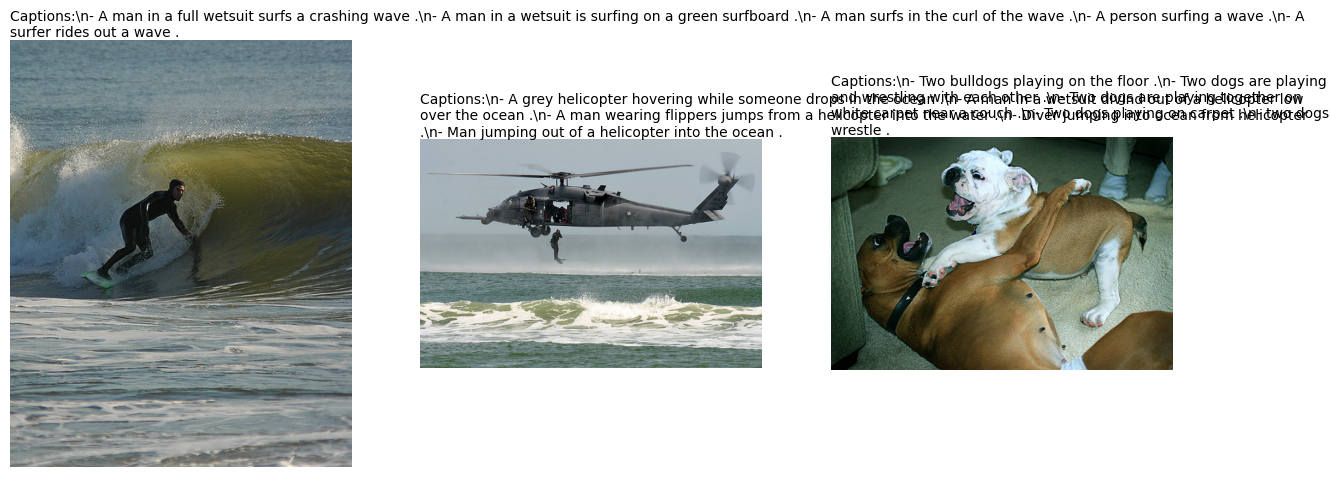

In [8]:
# Define the path to the images
IMAGE_PATH = 'archive/Images/'

# Display a few images and their captions
image_keys = list(caption_mapping.keys())
plt.figure(figsize=(15, 10))

for i in range(3):
    # Select a random image
    img_name = image_keys[np.random.randint(0, len(image_keys))]
    img = load_img(IMAGE_PATH + img_name)
    
    # Display the image
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    
    # Format the captions for display
    captions_formatted = '\\n'.join([f'- {c}' for c in caption_mapping[img_name]])
    ax.set_title(f'Captions:\\n{captions_formatted}', fontsize=10, pad=-60, loc='left', wrap=True)

plt.show()

### 2.3 Text Preprocessing and Tokenization

Before we can feed the captions to our model, we need to perform two key steps: cleaning the text and then converting the words into numerical tokens.

In [10]:
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetic characters
            caption = ''.join([char for char in caption if char.isalpha() or char.isspace()])
            # Remove short words
            caption = ' '.join([word for word in caption.split() if len(word) > 1])
            # Add start and end tokens
            caption = '<start> ' + caption + ' <end>'
            captions[i] = caption

# Clean the captions
clean_captions(caption_mapping)

# Create a flat list of all captions to build the vocabulary
all_captions_list = [caption for key in caption_mapping for caption in caption_mapping[key]]
print(f"Total captions after cleaning: {len(all_captions_list)}")
print("\nExample of a cleaned caption:")
print(all_captions_list[0])

# --- Tokenization ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions_list)

vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary Size: {vocab_size}")

max_caption_length = max(len(caption.split()) for caption in all_captions_list)
print(f"Maximum Caption Length: {max_caption_length}")

Total captions after cleaning: 40455

Example of a cleaned caption:
<start> start child in pink dress is climbing up set of stairs in an entry way end <end>

Vocabulary Size: 8766
Maximum Caption Length: 36


### 2.4 Image Feature Extraction with VGG16

Now we will process all the images through a pretrained VGG16 model. We will remove the final classification layer of the model and use the output of the preceding layer as a feature vector. This 4096 dimensional vector will represent the semantic content of each image.

This is a computationally intensive step, so we will run it once and store the extracted features in a dictionary for later use.

In [11]:
from tqdm import tqdm # Import tqdm for the progress bar

# Load the VGG16 model pretrained on ImageNet
vgg_model = VGG16()

# Restructure the model to remove the last layer (the classification layer)
# The new model's output will be the features from the second to last layer
feature_extractor = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

print("VGG16 model loaded and modified for feature extraction.")
print(feature_extractor.summary())

# --- Feature Extraction ---
# This dictionary will map image filenames to their feature vectors
image_features = {}
image_dir = 'archive/Images/'

# Using tqdm to create a progress bar
for img_name in tqdm(caption_mapping.keys(), desc="Extracting Features"):
    # Construct the full image path
    img_path = os.path.join(image_dir, img_name)
    
    # Load and resize the image for the VGG16 model
    image = load_img(img_path, target_size=(224, 224))
    
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    
    # Reshape the data for the model (add a batch dimension)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Preprocess the image for the VGG model
    image = preprocess_input(image)
    
    # Get the features
    feature = feature_extractor.predict(image, verbose=0)
    
    # Store the feature vector
    image_features[img_name] = feature

print(f"\nFinished feature extraction for {len(image_features)} images.")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
VGG16 model loaded and modified for feature extraction.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Extracting Features: 100%|██████████| 8091/8091 [27:05<00:00,  4.98it/s]

\nFinished feature extraction for 8091 images.


## 3. Data Generator and Train/Test Split

To train our model, we need to feed it data in batches. A data generator is a memory efficient way to do this. The generator will create sequences of data for the model to learn from. For each caption, it will create multiple input/output pairs.

For example, for the caption `<start> a dog runs <end>`, the generator will produce the following pairs:
- Input: `[image_feature]`, `<start>` -> Output: `a`
- Input: `[image_feature]`, `<start> a` -> Output: `runs`
- Input: `[image_feature]`, `<start> a runs` -> Output: `<end>`

First, let's split our image keys into a training and a validation set.

In [12]:
from sklearn.model_selection import train_test_split

# Get all image keys
all_image_keys = list(caption_mapping.keys())

# Split into training and validation sets (e.g., 80% train, 20% validation)
train_keys, val_keys = train_test_split(all_image_keys, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_keys)}")
print(f"Number of validation images: {len(val_keys)}")

Number of training images: 6472
Number of validation images: 1619


In [20]:
from tensorflow.keras.utils import to_categorical

def data_generator(keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # This function will run indefinitely
    while True:
        # Select a random set of image keys for the batch
        batch_keys = np.random.choice(keys, size=batch_size, replace=False)
        
        # Initialize lists for the batch
        X1, X2, y = [], [], []
        
        for key in batch_keys:
            captions = mapping[key]
            
            # For each caption of the image
            for caption in captions:
                # Convert caption to a sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Create input-output pairs from the sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # Pad the input sequence to max_length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # One-hot encode the output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Append to the batch lists
                    X1.append(features[key][0]) # Image features
                    X2.append(in_seq)           # Text sequence
                    y.append(out_seq)           # Next word
        
        # The inputs must be yielded as a tuple, not a list
        yield ((np.array(X1), np.array(X2)), np.array(y))

## 4. Model Architecture

We will now define our image captioning model. It follows an encoder/decoder architecture:

1.  **Image Feature Pathway:** A `Dense` layer processes the image features to match the dimensionality of the text pathway. A `Dropout` layer is added for regularization.
2.  **Text Pathway:** An `Embedding` layer converts the integer encoded text sequence into dense vectors. A `Dropout` layer is also added here.
3.  **Merge:** The outputs from both pathways are added together.
4.  **Decoder:** An `LSTM` layer processes the merged sequence to learn temporal dependencies.
5.  **Output:** A final `Dense` layer with a softmax activation function produces a probability distribution over the entire vocabulary for the next word in the caption.

In [21]:
from tensorflow.keras.layers import add

def define_captioning_model(vocab_size, max_length):
    # --- Image Feature Pathway ---
    # Input layer for the 4096-dim feature vector
    input_features = Input(shape=(4096,))
    # Dropout for regularization
    fe1 = Dropout(0.5)(input_features)
    # Dense layer to map features to the embedding dimension
    fe2 = Dense(256, activation='relu')(fe1)

    # --- Text Pathway ---
    # Input layer for the text sequence
    input_seq = Input(shape=(max_length,))
    # Embedding layer to create word vectors
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_seq)
    # Dropout for regularization
    se2 = Dropout(0.5)(se1)
    # LSTM layer
    se3 = LSTM(256)(se2)

    # --- Merge (Decoder) ---
    # Add the outputs from both pathways
    decoder1 = add([fe2, se3])
    # Dense layer
    decoder2 = Dense(256, activation='relu')(decoder1)
    # Final output layer
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Create the final model
    model = Model(inputs=[input_features, input_seq], outputs=outputs)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# Define the model
model = define_captioning_model(vocab_size, max_caption_length)

# Print the model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 36, 256)   │  2,244,096 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4096)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 36, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 36)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8766)      │  2,252,862 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

Now we will train our model. We will use the `data_generator` to create batches of data and feed them to the model using the `fit()` method. We will also create a separate generator for our validation data to monitor the model's performance on unseen images during training.

In [22]:
# Define training parameters
BATCH_SIZE = 64
EPOCHS = 10 # Start with 10 epochs, more can lead to better results but take longer

# --- Create the Data Generators ---
# Training data generator
train_generator = data_generator(train_keys, caption_mapping, image_features, tokenizer, max_caption_length, vocab_size, BATCH_SIZE)
# Validation data generator
val_generator = data_generator(val_keys, caption_mapping, image_features, tokenizer, max_caption_length, vocab_size, BATCH_SIZE)

# Calculate steps per epoch
# Training steps: number of training images divided by batch size
steps_per_epoch = len(train_keys) // BATCH_SIZE
# Validation steps: number of validation images divided by batch size
validation_steps = len(val_keys) // BATCH_SIZE

# --- Fit the Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=1
)

print("\n--- Model Training Complete ---")

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 4.8527 - val_loss: 4.1020
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - loss: 3.6664 - val_loss: 3.5573
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - loss: 3.2175 - val_loss: 3.3705
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - loss: 2.9520 - val_loss: 3.3113
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - loss: 2.7647 - val_loss: 3.2671
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - loss: 2.6194 - val_loss: 3.2689
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - loss: 2.4934 - val_loss: 3.2056
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - loss: 2.3933 - val_loss: 3.2649
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - loss: 2.3053 - val_loss: 3.2575
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - loss: 2.2461 - val_loss: 3.2665

--- Model Training Complete ---
